1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
import pandas as pd
df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv')
df = df.drop(['Unnamed: 0'],1)

df.head(5)

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [2]:
df["default"] = df["default"].astype('category')
df["student"] = df["student"].astype('category')
print(df["default"])
df["default"]= df["default"].cat.rename_categories([0,1])
df["student"] = df["student"].cat.rename_categories([0,1])
print(df["default"])

#df_default=pd.get_dummies(df['default'])
#df_student=pd.get_dummies(df['student'])
    
#df_final = pd.concat([df_default,df_student,df[['balance','income']]],axis=1)

df.head(5)
#df_final.head(5)

0        No
1        No
2        No
3        No
4        No
5        No
6        No
7        No
8        No
9        No
10       No
11       No
12       No
13       No
14       No
15       No
16       No
17       No
18       No
19       No
20       No
21       No
22       No
23       No
24       No
25       No
26       No
27       No
28       No
29       No
       ... 
9970     No
9971     No
9972     No
9973     No
9974     No
9975     No
9976     No
9977     No
9978    Yes
9979     No
9980     No
9981     No
9982     No
9983     No
9984     No
9985     No
9986     No
9987     No
9988     No
9989     No
9990     No
9991     No
9992     No
9993     No
9994     No
9995     No
9996     No
9997     No
9998     No
9999     No
Name: default, dtype: category
Categories (2, object): [No, Yes]
0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20 

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


In [3]:
df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

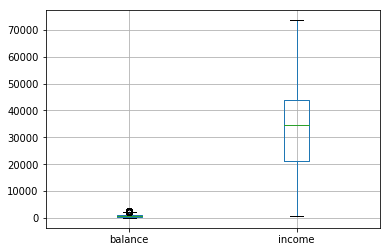

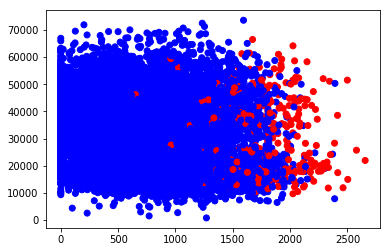

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df.boxplot(return_type='axes')
plt.show()

color= ['red' if default == 1 else 'blue' for default in df.default]
plt.scatter(df.balance, df.income, color=color)
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

/Users/verayujiefeng/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Area under the ROC curve : 0.932928


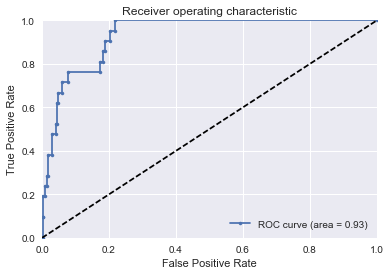

In [5]:
# Necssary libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
#from mpl_toolkits.basemap import Basemap
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random

#our dataset
df_1 = df[df.student != 0]
y = df_1['default']
X = df_1.drop(['default'],1)

# K-fold cross validation for model selection.
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
   
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)




In [6]:
np.array(y)

array([0, 0, 0, ..., 0, 0, 0])

In [7]:
X.shape

(2944, 3)

In [27]:
#add decision boundary to the previous scatter plot

theta = 0.5

def sigmoid(z):
    print(z.shape)
    print(np.exp(-z))
    return 1 / (1 + np.exp(-z))

def cost(theta, X, y):
    #theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(np.log(sigmoid(X*theta[0])), -y)
    second = np.multiply(np.log(1-sigmoid(X * theta[0])), (1-y))
    return np.sum(first -  second)/(len(X))

def gradient(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    error = sigmoid(X*theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / len(X)
        
    return grad

import scipy.optimize as opt

result = opt.fmin_tnc(func=cost, x0=theta, args=(X, np.array(y)), 
                      #fprime=gradient
                     )
#cost(X, y, result[0])
bound = decision_boundary(y)

color= ['red' if default == 1 else 'blue' for default in df.default]
plt.scatter(df.balance, df.income, bound, color=color)
plt.show()


(2944, 3)


AttributeError: 'float' object has no attribute 'exp'

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

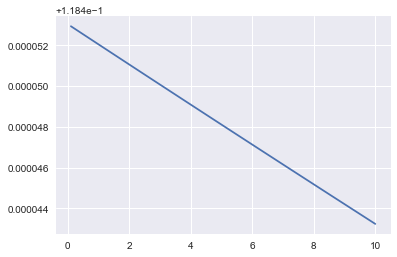

Area under the ROC curve : 0.962252262573


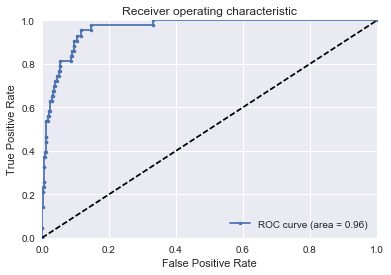

In [28]:
#df = df[df['student'] != 0]
#df = df[df.student != 0]
#df.head(5)

y = df['default']
X = df.drop(['default'],1)
size = len(y)

# Split the data into training/testing sets
X_train = X[0:int(size*0.8)]
X_test = X[int(size*0.8):]

# Split the targets into training/testing sets
y_train = y[0:int(size*0.8)]
y_test = y[int(size*0.8):]

# Create linear regression object
alphas = np.logspace(-1,1,30)

scores = []

for alpha in alphas:
    regr = Ridge(alpha=alpha)

    # Train the model using the training sets
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test,y_test))
plt.plot(alphas,scores)
plt.show()

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve :", roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)




6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [29]:
# K-fold cross validation for model selection.
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
   
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred


7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

Visualize the decision tree & Use R^2 to compare performance

In [30]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy.random as nprnd
import random
import seaborn
%matplotlib inline

#our dataset
df_1 = df[df.student != 0]
y = df_1['default']
X = df_1.drop(['default'],1)

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=1)
regr_2 = DecisionTreeRegressor(max_depth=2)
regr_3 = DecisionTreeRegressor(max_depth=3)
regr_4 = DecisionTreeRegressor(max_depth=4)
regr_5 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)
regr_4.fit(X, y)
regr_5.fit(X, y)

# Predict
df_ran = df_1.sample(frac=0.7)
y_test = df_ran['default']
X_test = df_ran.drop(['default'],1)
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3 = regr_3.predict(X_test)
y_4 = regr_4.predict(X_test)
y_5 = regr_5.predict(X_test)

#define a function to visualize the tree
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

#import libraries for visualizing the decision tree
from __future__ import print_function
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image  
import pydotplus 
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.externals.six import StringIO

#plot the decision tree for depth=1

#dot_data = StringIO() 
#dt=DecisionTreeRegressor(max_depth=1)
#tree.export_graphviz(dt, out_file=dot_data, feature_names=X.columns)  
#graph = pydot.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png()) 

dot_data = StringIO()
dt=DecisionTreeRegressor(max_depth=1)
print(type(tree))
tree.export_graphviz(dt, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("iris.pdf")
Image(graph.create_png()) 

#dt=DecisionTreeRegressor(max_depth=1)
#visualize_tree(regr_1, feature_names=['x'])
#dot_data= tree.export_graphviz(regr_1, outfile=None)
#tree.export_graphviz(dt, out_file=dot_data, feature_names=X.columns) 
#graph = pydot.graph_from_dot_data(dot_data)  
#graph = pydot.graphviz.graph_from_dot_data(dot_data)  
#Image(graph.create_png()) 

#plot the decision tree for depth=2
dt=DecisionTreeRegressor(max_depth=2)
visualize_tree(regr_2, feature_names=['x'])
dot_data=export_graphviz(regr_2, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

#plot the decision tree for depth=3
dt=DecisionTreeRegressor(max_depth=3)
visualize_tree(regr_3, feature_names=['x'])
dot_data=export_graphviz(regr_3, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

#plot the decision tree for depth=4
dt=DecisionTreeRegressor(max_depth=4)
visualize_tree(regr_4, feature_names=['x'])
dot_data=export_graphviz(regr_4, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

#plot the decision tree for depth=5
dt=DecisionTreeRegressor(max_depth=5)
visualize_tree(regr_5, feature_names=['x'])
dot_data=export_graphviz(regr_5, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 





<class 'module'>


AttributeError: 'NoneType' object has no attribute 'children_left'

In [ ]:
#our dataset
df_1 = df[df.student != 0]
y = df_1['default']
X = df_1.drop(['default'],1)

#compute R^2
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,6)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]
print('The optimal depth is ' + str(n_opt))


The following code is tryout for 3d plot of regression model to compare the performance.

In [ ]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy.random as nprnd
import random
import seaborn
%matplotlib inline
#3d plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

df_1 = df[df.student != 0]
y = df_1['default']
X = df_1.drop(['default'],1)

# Fit regression model
#depth = str(range(1,6))
depths = [('1','cornflowerblue'), ('2','red'),('3','green'),('4','yellow'),('5','purple')]
for (n, color) in depths:
    #fit regression model
    regr = DecisionTreeRegressor(max_depth=int(n))
    regr.fit(X, y)
    #predict
    df_ran = df_1.sample(frac=0.7)
    y_test = df_ran['default']
    X_test = df_ran.drop(['default'],1)
    y_predict = regr.predict(X_test)
    # Plot the results
    plt.figure()
    plt.scatter(X_test, y_test, c="black", label="data")
    plt.plot(X_test, y_predict, color=color, label="max_depth="+n, linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Decision Tree Regression")
    plt.legend()
    plt.show()


8) Find the optimal decision tree depth and compute the AUC ROC. 

From (7), we know the optimal decision tree depth is 2.

In [ ]:
# Create linear regression object
alphas = np.logspace(-3,-1,30)

scores = []

for alpha in alphas:
    #regr = LogisticRegression(C=alpha,penalty='l1')
    regr = DecisionTreeRegressor(max_depth=2)

    # Train the model using the training sets
    regr.fit(X_train, y_train)
    
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,LogisticRegression,C=alpha,penalty='l1')
    scores.append(roc_auc)
plt.plot(alphas,scores)

In [ ]:
regr.score(X_test,y_test)

In [ ]:
alpha_best = alphas[np.argmax(scores)]
print(alpha_best)